<a href="https://colab.research.google.com/github/omerkark/HHD/blob/main/HDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#settings

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: protobuf, tensorboard, h5py, keras-preprocessing, flatbuffers, typing-extensions, wrapt, absl-py, gast, google-pasta, termcolor, numpy, grpcio, opt-einsum, wheel, six, tensorflow-estimator, astunparse
Required-by: fancyimpute


In [ ]:
import cv2
import os
import re
import numpy as np
import tensorflow as tf
import keras
import pickle as pkl
import matplotlib.pyplot as plt
import random
from keras.models import load_model
from keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
%matplotlib inline

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
padSize = 0
directoryTEST = r'/content/gdrive/MyDrive/HDD_data/TEST'
directoryTRAIN = r'/content/gdrive/MyDrive/HDD_data/TRAIN'
directoryTEST_RAW = r'/content/gdrive/MyDrive/HDD_data/TEST_RAW'
directoryTRAIN_RAW = r'/content/gdrive/MyDrive/HDD_data/TRAIN_RAW'
numOfClasses = 0

In [ ]:
_nsre = re.compile('([0-9]+)')
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)]

def sort_folders_by_name(directory):
    folderList = []
    for filename in os.listdir(directory):
        pathTest = os.path.join(directory, filename)
        folderList.append(pathTest)
    folderList.sort(key=natural_sort_key)
    return folderList

In [ ]:
def print_num_of_class(directory): 
  i =0 
  for file in os.listdir(directory): 
    pathTest = os.path.join(directory, file)
    for image in os.listdir(pathTest):
        pathImage = os.path.join(pathTest, image) 
        print(int(file))
        i += 1
  print(i)

#Pre Proccess

In [ ]:

def processImgSize(directory):
    classNo = []
    images = []
    tuple_array = []
    numOfClasses =0
    print("loading {}.....".format(directory))
    for file in sort_folders_by_name(directory):
        pathTest = os.path.join(directory, file)
        print(numOfClasses, end=" ")
        for image in os.listdir(pathTest):
            pathImage = os.path.join(pathTest, image)
            # print(pathImage)
            # print(pathImage)
            img = cv2.imread(pathImage)
            hight, width = img.shape[:2]
            if width < hight:
                padSize = int((hight - width)/2)
                img = cv2.copyMakeBorder(img, 0, 0, padSize, padSize, cv2.BORDER_CONSTANT,
                                       value=[255, 255, 255])
            elif hight < width:
                    padSize = int((width - hight)/2)
                    img = cv2.copyMakeBorder(img, padSize, padSize, 0, 0, cv2.BORDER_CONSTANT,
                                             value=[255, 255, 255])
            img = cv2.resize(img, (64, 64))
            try:
                 img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            except:
                 print('already 1 channel')
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            #img = img / 255.0
            # images.append(img)
            #classNo.append(int(file))
            # classNo.append(numOfClasses)
            ##cv2.imwrite(pathImage, img)

            ############################################# NEW CODE###################################
            img=np.array(img)
            img = img.astype('float32')
            img /= 255 
            ## each image with its label in a tuple appended to tuple_array
            data_tuple = (img , numOfClasses)
            tuple_array.append(data_tuple)
            #########################################################################################
        
        numOfClasses = numOfClasses + 1
    #turn them into numpy arraya for proccessing
   
     ############################################# NEW CODE###################################
     ## sort the array and from every elemt tuple of data_label build the images and lables arrays. 
    random.shuffle(tuple_array)
    for img_label in tuple_array:
      images.append(img_label[0])
      classNo.append(img_label[1])
     #########################################################################################
    images = np.array(images)
    classNo = np.array(classNo)
    # images  = tf.convert_to_tensor(images)
    # classNo = tf.convert_to_tensor(classNo)
    print('\nimages array shape: ' , images.shape)
    print('label array shape: ' , classNo.shape)
    return images, classNo

In [ ]:
X_train, y_train = processImgSize(directoryTRAIN_RAW)
X_test, y_test = processImgSize(directoryTEST_RAW)

loading /content/gdrive/MyDrive/HDD_data/TRAIN_RAW.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
images array shape:  (3809, 64, 64, 3)
label array shape:  (3809,)
loading /content/gdrive/MyDrive/HDD_data/TEST_RAW.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
images array shape:  (1090, 64, 64, 3)
label array shape:  (1090,)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Model Setup

In [ ]:
# load model without classifier layers
model = VGG19(include_top=False, input_shape=(64, 64, 3))
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(27, activation='softmax')(class1)
#output = Dense(27, activation='sigmoid')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

#Saving the arrays with pickle




In [ ]:


pickle_path = r'/content/gdrive/MyDrive/HDD_data/saved_pickle'

filename_X_Train = pickle_path + '/X_train_array'
filename_y_Train = pickle_path + '/y_train_array'
filename_X_Test = pickle_path + '/X_test_array'
filename_y_Test = pickle_path + '/y_test_array'

def save_files(fileName , data):
    fileObject = open(fileName, 'wb')
    pkl.dump(data, fileObject)
    fileObject.close()

save_files(filename_X_Train, X_train)
save_files(filename_y_Train, y_train)

save_files(filename_X_Test, X_test)
save_files(filename_y_Test, y_test)

# training the model


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss = 'categorical_crossentropy', optimizer = opt , metrics = ['accuracy'])
#model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train , validation_split=0.3, epochs=20)

Epoch 1/20
84/84 [==============================] - 6s 68ms/step - loss: 0.1036 - accuracy: 0.9655 - val_loss: 0.7565 - val_accuracy: 0.8460
Epoch 2/20
84/84 [==============================] - 6s 67ms/step - loss: 0.1099 - accuracy: 0.9662 - val_loss: 0.6033 - val_accuracy: 0.8784
Epoch 3/20
84/84 [==============================] - 6s 68ms/step - loss: 0.0825 - accuracy: 0.9730 - val_loss: 0.5840 - val_accuracy: 0.8801
Epoch 4/20
84/84 [==============================] - 6s 68ms/step - loss: 0.0647 - accuracy: 0.9794 - val_loss: 0.5343 - val_accuracy: 0.8915
Epoch 5/20
84/84 [==============================] - 6s 68ms/step - loss: 0.0333 - accuracy: 0.9884 - val_loss: 0.5755 - val_accuracy: 0.8793
Epoch 6/20
84/84 [==============================] - 6s 68ms/step - loss: 0.0424 - accuracy: 0.9842 - val_loss: 0.5540 - val_accuracy: 0.8889
Epoch 7/20
84/84 [==============================] - 6s 68ms/step - loss: 0.0744 - accuracy: 0.9756 - val_loss: 0.5243 - val_accuracy: 0.8871
Epoch 8/20
84

In [ ]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 1s 20ms/step - loss: 0.6862 - accuracy: 0.8936


[0.6861520409584045, 0.8935779929161072]

#saving the model


In [ ]:
model.save('/content/gdrive/MyDrive/HDD_data/VGG_model_save')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/HDD_data/VGG_model_save/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/HDD_data/VGG_model_save/assets


# upload model

In [ ]:

# model = keras.models.load_model('/content/gdrive/MyDrive/HDD_data/VGG_model_save')

# def load_npArray(fileName):
#     fileObject = open(fileName, 'rb')
#     modelInput = pkl.load(fileObject)
#     fileObject.close()
#     return modelInput


# pickle_path = r'/content/gdrive/MyDrive/HDD_data/saved_pickle'
# filename_X_Test = pickle_path + '/X_test_array'
# filename_y_Test = pickle_path + '/y_test_array'


# X_test = load_npArray(filename_X_Test)
# y_test = load_npArray(filename_y_Test)

#predictions

In [ ]:
testImg1 = cv2.imread('/content/gdrive/MyDrive/HDD_data/8_187.png')
testImg = cv2.imread('/content/gdrive/MyDrive/HDD_data/14_164.png')
testImg3 = cv2.imread('/content/gdrive/MyDrive/HDD_data/22_168.png')

In [ ]:
labels = ['א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'כ' ,'ך','ל','מ','ם','נ','ן','ס','ע','פ','ף','צ','ץ','ק','ר','ש','ת']
#labels = ['א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'כ' ,'ך','ל','מ','ם','נ','ן','ס','ע','פ']

In [ ]:
def predict_single_picture(testImg):
    plt.imshow(testImg)
    testImg = np.expand_dims(testImg, axis=0)
    answer = np.argmax(model.predict(testImg),axis=1)
    print(answer)
    print(labels[answer[0]])

#single letter


In [ ]:
# predict_single_picture(testImg1)

In [ ]:
# predict_single_picture(testImg)

In [ ]:
# predict_single_picture(testImg3)

In [ ]:
# train_img26 =  cv2.imread('/content/gdrive/MyDrive/HDD_data/26_14.png')
# predict_single_picture(train_img26)

In [ ]:
model.metrics_names

['loss', 'accuracy']

# Comfusion matrix layouts

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# print(classification_report(y_test, y_pred, target_names=target_names, digits=4))
predictions = model.predict(X_test)
# print(predictions[1])
# print(y_test[0])
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)

[[44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0]
 [ 0 36  2  0  1  0  0  0  0  0  0  3  0  1  2  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0 41  0  0  0  0  0  1  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0]
 [ 0  1  0 38  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  4  0  0
   0  0  0]
 [ 0  1  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0 33  0  0  0  6  0  0  0  0  0  0  6  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0 42  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  2]
 [ 0  0  0  0  1  0  0 41  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  1  0  0  0  0  0 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 1  0  1  0  0  4  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 40  1  0  0  0  0  0  0  0  0  0  0  0  0
   2  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0 24  1  0  1  0  0  

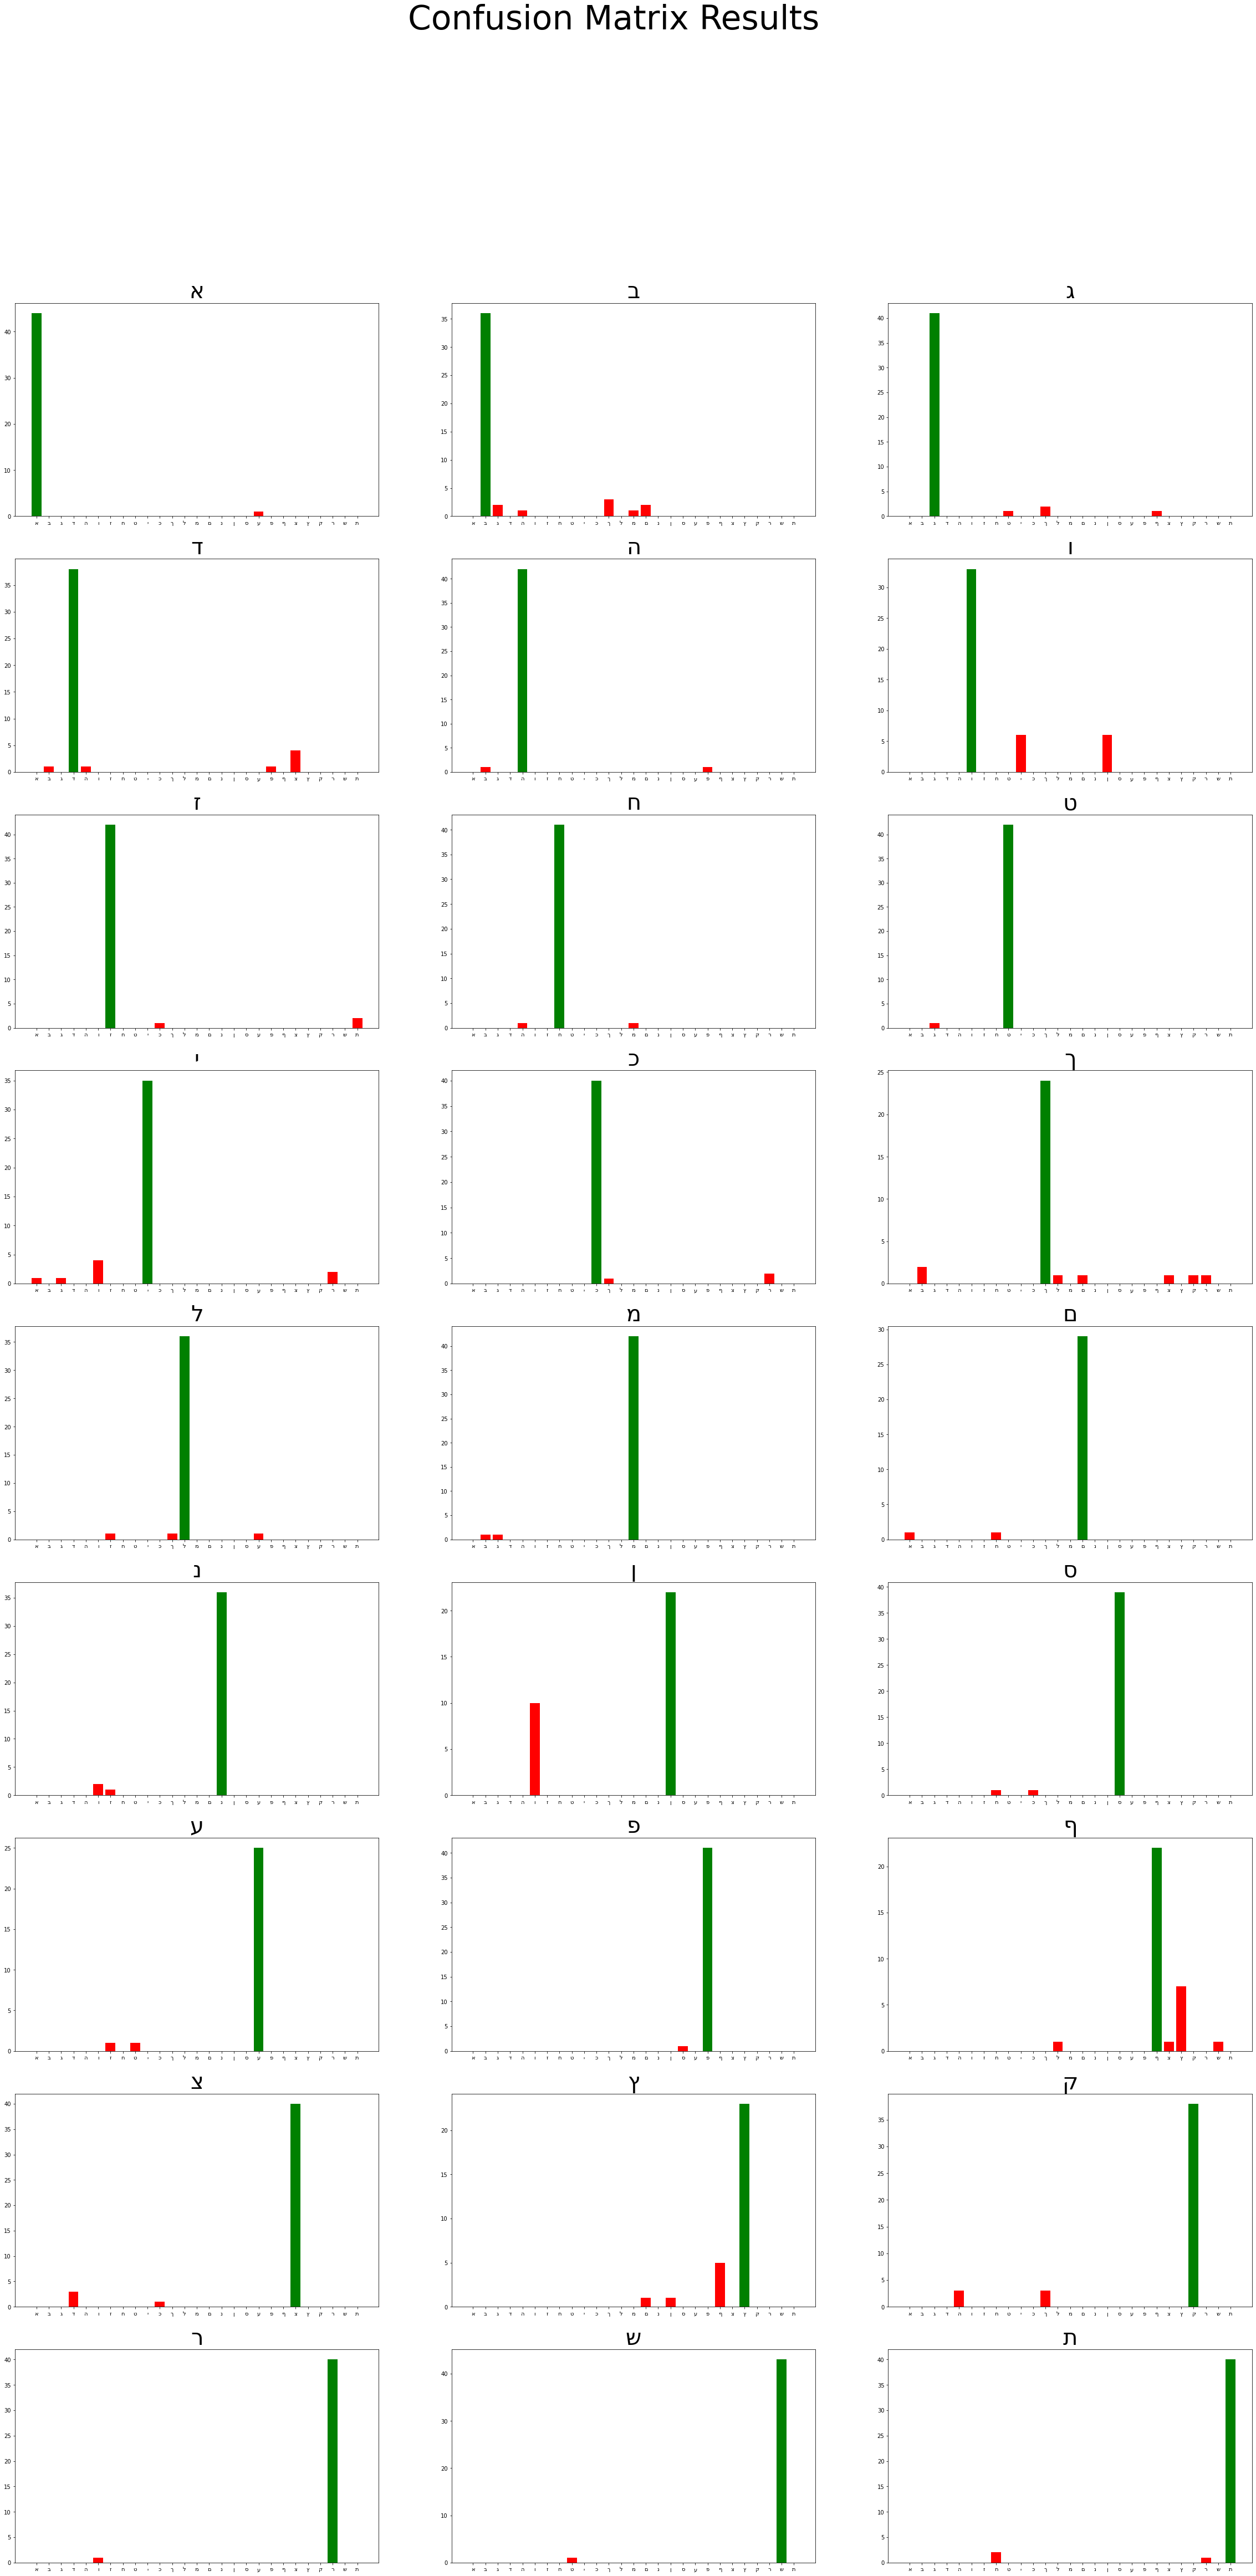

In [ ]:
def swapColors(colors , k):
  if k < len(colors):
    colors[k], colors[k-1] = colors[k-1], colors[k]
  return colors

colors = [27]
colors[0] = 'green'
for i in range (1,27):
  colors.append('red')

fig, axs = plt.subplots(9, 3, figsize=(40,75))
fig.suptitle('Confusion Matrix Results', fontsize = 60)
k = 0
for i in range (0,9):
  for j in range (0,3):
    axs[i,j].bar(labels, cm[k], color = colors)
    axs[i,j].set_title(labels[k], fontsize=40)
    k = k+1
    colors = swapColors(colors, k)


#plt.subplots_adjust(wspace=0.2, hspace=0.3)

fig.savefig('/content/gdrive/MyDrive/HDD_data/confusionMatrixRes.png', bbox_inches='tight')
##fig.tight_layout()




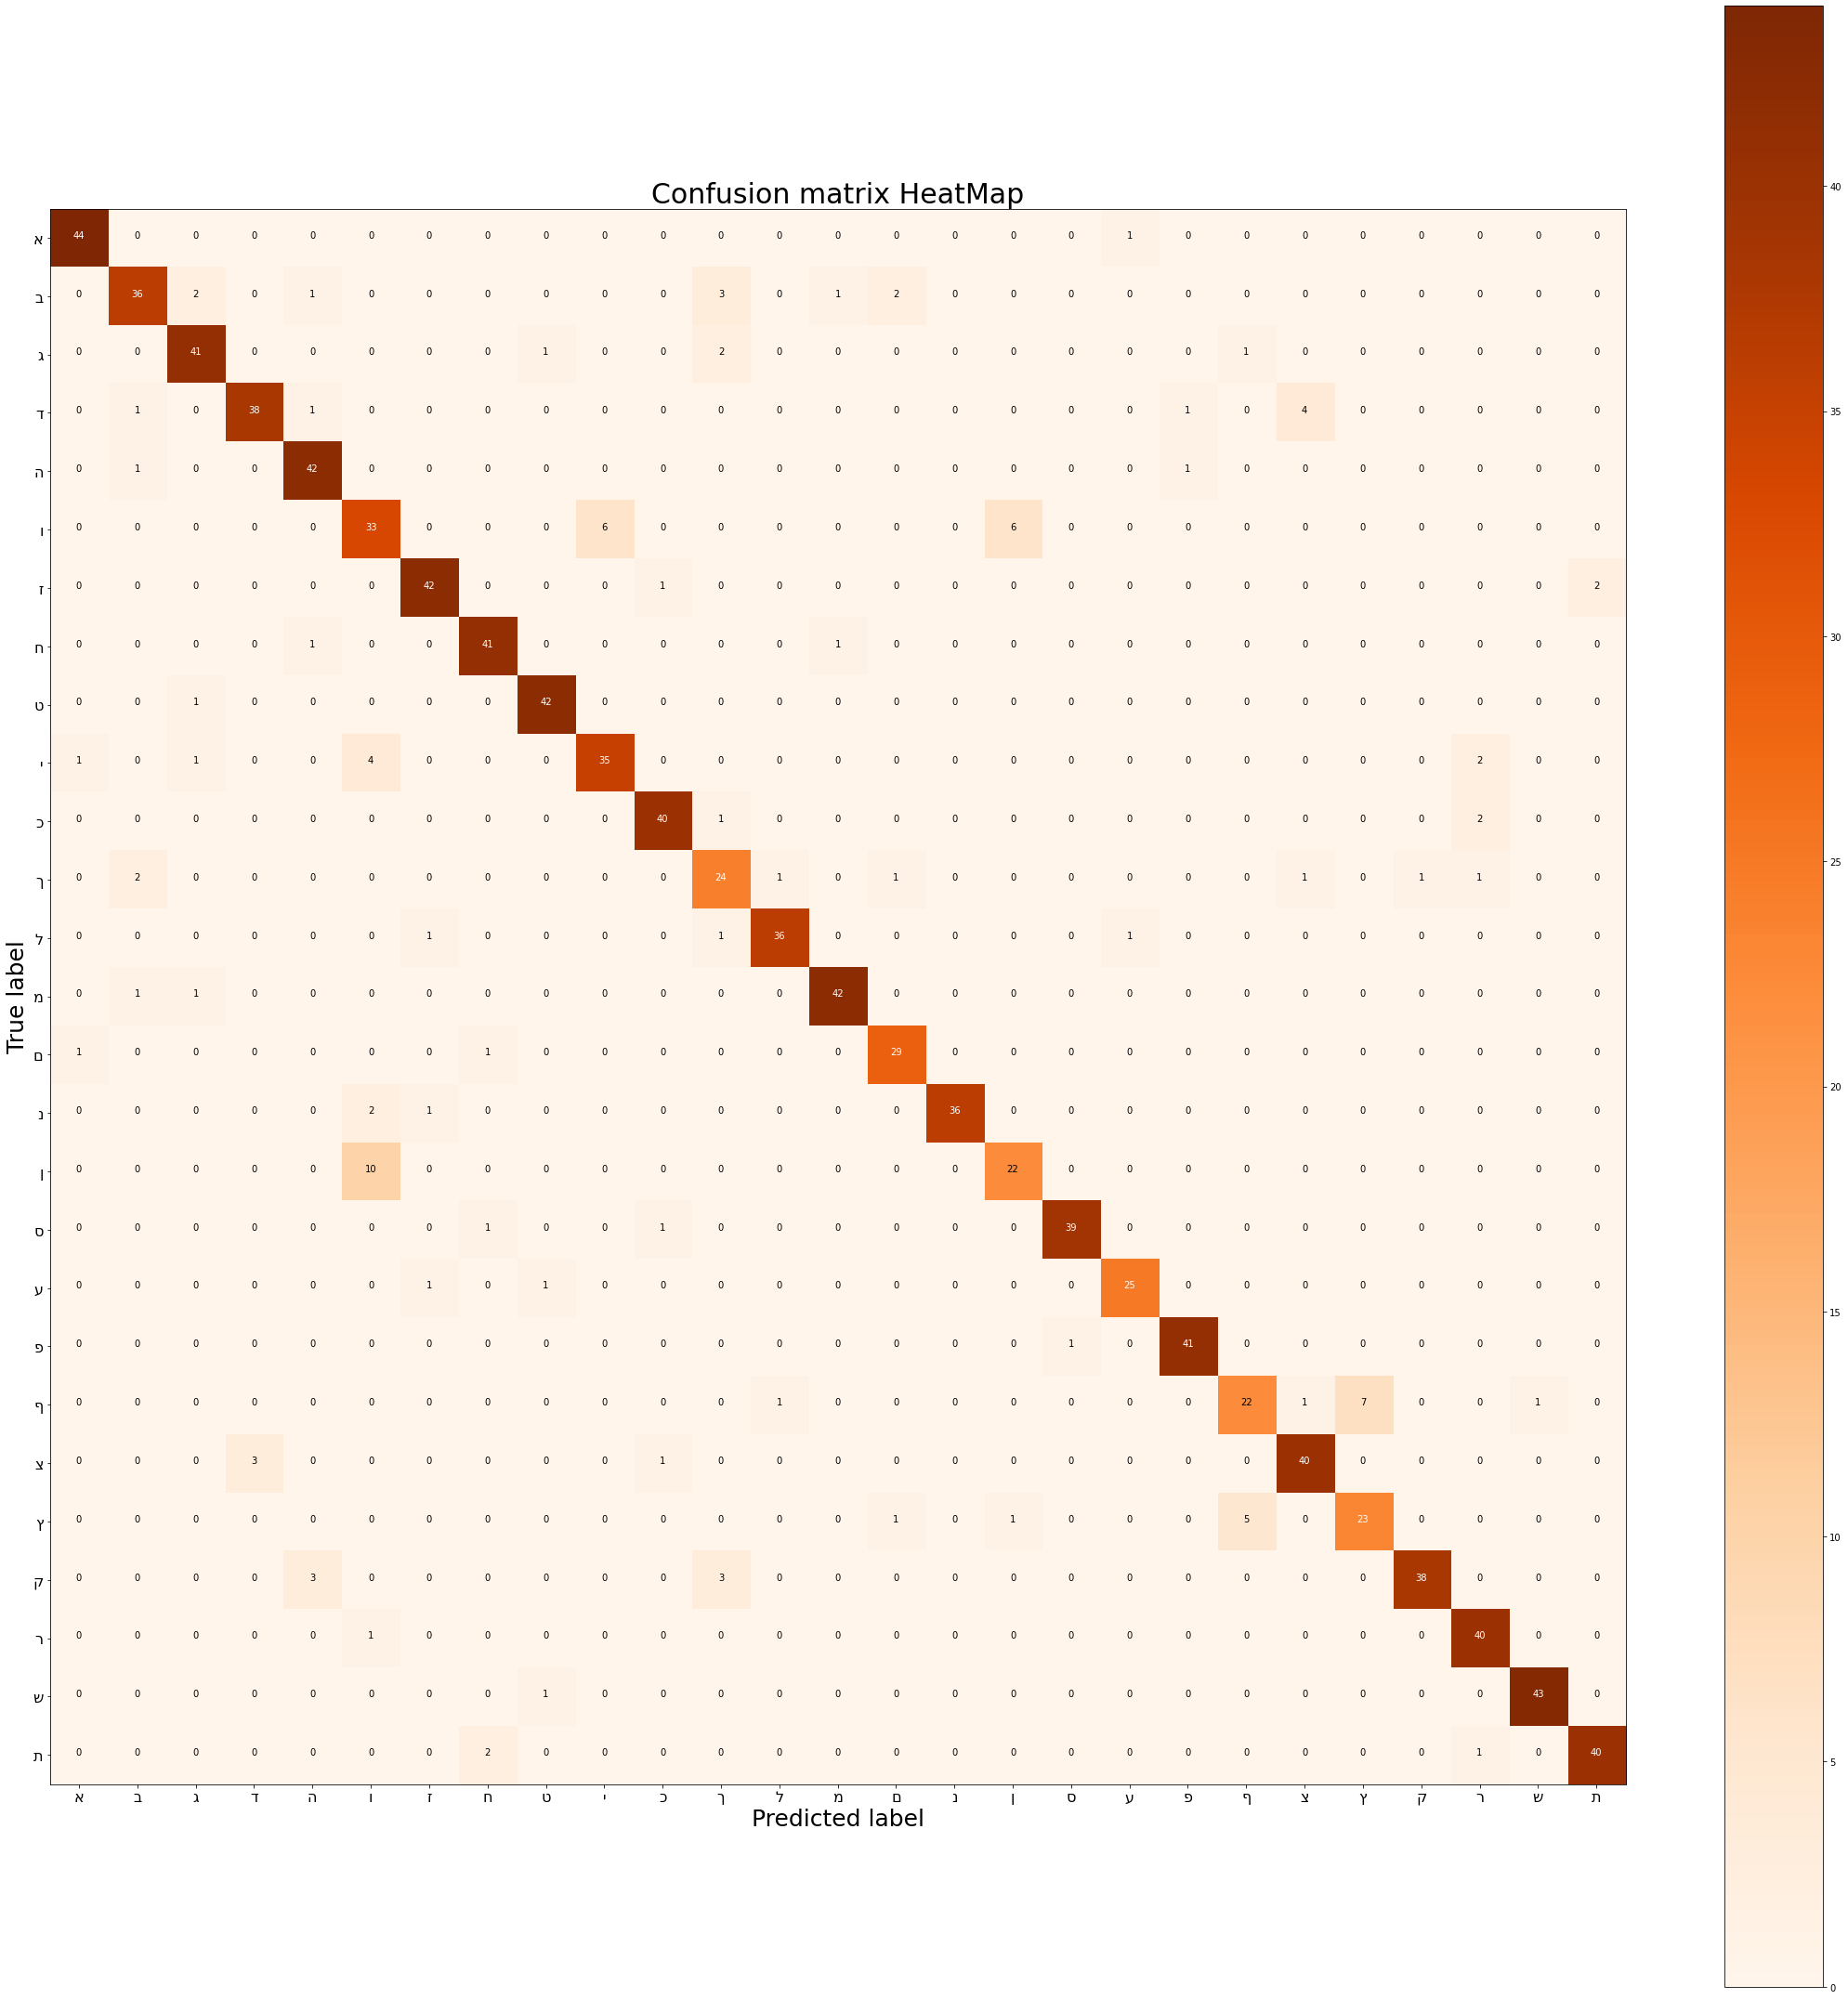

In [ ]:
import itertools
def plot_confusion_matrix(fig, cm, classes, 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title, fontsize = 30)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, fontsize = 16)
  plt.yticks(tick_marks, classes,  fontsize = 16)

  fmt = '.0f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label', fontsize=25)
  plt.xlabel('Predicted label', fontsize=25)
  plt.show()
  return fig
 


# Compute confusion matrix
# y_pred = np.argmax(predictions, axis=1)
# cnf_matrix = confusion_matrix(test_labels, y_pred)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(30,30))
fig2 = plot_confusion_matrix(fig, cm, classes=labels, 
                      title='Confusion matrix HeatMap')
fig2.savefig('/content/gdrive/MyDrive/HDD_data/confusionMatrixHeatMap.png', bbox_inches='tight')


# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

In [ ]:
  # colors = [27]
  # colors[0] = 'blue'
  # for i in range (1,26):
  #     colors.append('red')

  # plt.bar(labels, cm[0], color = colors)
  # plt.title(labels[0], fontsize=25)
  # plt.figure(figsize=(10,10))
  # plt.show()

  # plt.bar(labels, cm[25], color = colors)
  # plt.title(labels[25], fontsize=25)
  # plt.figure(figsize=(10,10))
  # plt.show()

  # plt.bar(labels, cm[24], color = colors)
  # plt.title(labels[24], fontsize=25)
  # plt.figure(figsize=(10,10))
  # plt.show()

#Error analysis


In [ ]:
miss_classification_path = r'/content/gdrive/MyDrive/HDD_data/Miss_Classified_Images'

labels = ['א', 'ב', 'ג', 'ד', 'ה', 'ו', 'ז', 'ח', 'ט', 'י', 'כ' ,'ך','ל','מ','ם','נ','ן','ס','ע','פ','ף','צ','ץ','ק','ר','ש','ת']
# print(X_test.shape)
# # print(y_test.shape)
# img = cv2.imread('/content/gdrive/MyDrive/HDD_data/14_164.png')

# testImg = X_test[90]
# testHotLabel = y_test[70]
# testImgExpandDim = np.expand_dims(testImg, axis=0)
# prediction = np.argmax(model.predict(testImgExpandDim),axis=1)
#   # if (testHotLabel[prediction] != 1): 
#      ## This means that the prediction was not like the true label
#      ## Save the image with the name of the predicted label. 
# predictionLabel = labels[prediction[0]]
# print(type(predictionLabel))
# predictionLabelPng = 'bla.png'
# pathImage = os.path.join(miss_classification_path, predictionLabelPng)
# print(pathImage)
# print(testImg)


# rgb = PIL.Image.fromarray(testImg)
# cv2.imwrite(pathImage, rgb)

# # imgplot = plt.imshow(X_test[1000])
# fig.savefig(pathImage, bbox_inches='tight')


# directory = r'/content/gdrive/MyDrive/HDD_data/TEST_RAW'

# for file in sort_folders_by_name(directory):
#         pathTest = os.path.join(directory, file)
#         print(numOfClasses, end=" ")
#         for image in os.listdir(pathTest):
#           pathImage = os.path.join(pathTest, image)
#             img = cv2.imread(pathImage)
#             hight, width = img.shape[:2]
#             if width < hight:
#                 padSize = int((hight - width)/2)
#                 img = cv2.copyMakeBorder(img, 0, 0, padSize, padSize, cv2.BORDER_CONSTANT,
#                                        value=[255, 255, 255])
#             elif hight < width:
#                     padSize = int((width - hight)/2)
#                     img = cv2.copyMakeBorder(img, padSize, padSize, 0, 0, cv2.BORDER_CONSTANT,
#                                              value=[255, 255, 255])
#             img = cv2.resize(img, (64, 64))
#             try:
#                  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             except:
#                  print('already 1 channel')
#             img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)



# print(X_test[0].shape)
# testImg = X_test[0]
# plt.imshow(testImg)
# testImg = np.expand_dims(testImg, axis=0)
# print(testImg.shape)
# prediction = np.argmax(model.predict(testImg),axis=1)
# print('prediction: ' , prediction)
# if (y_test[0][prediction] == 1):
#   print('prediction == label')
# else:
#   print('prediction != label')

# print(y_test[0])







# my_name = str(8) + '_' + str(9) + '.png'
# this_path = os.path.join(miss_classification_path, my_name)
# cv2.imwrite(this_path, img)



import imageio
# imageio.imwrite(pathImage, testImg)

#########################     THE CODE THAT I WANT #########################

for i in range(0 , len(X_test)):
    testImg = X_test[i]
    testHotLabel = y_test[i]
    testLabel = np.argmax(testHotLabel)

    testImgExpandDim = np.expand_dims(testImg, axis=0)
    prediction = np.argmax(model.predict(testImgExpandDim),axis=1)
    if (testLabel != prediction): 
        ## This means that the prediction was not like the true label
        ## Save the image with the name of the predicted label. 
        predictionLabel = labels[prediction[0]]
        testLabelHeb = labels[testLabel]
        print(predictionLabel)
        # print(predictionLabel)
        print(testLabelHeb)

        ## add numbers
        predictionLabelPng = str(i) + 'prediction:' + predictionLabel + ' -- ' + 'trueL:' + testLabelHeb + '_' + '.png'
        # print(type(predictionLabelPng))
        # print(predictionLabelPng)
        pathImage = os.path.join(miss_classification_path, predictionLabelPng)
        # print(pathImage)
        imageio.imwrite(pathImage, testImg)


####################### UNTIL HERE########################################3


# # print(type(data_label_array))
# print(data_label_array.shape)

# print('shapes')
# print(y_test[4])



# for data_label in data_label_array:
#   prediction = np.argmax(model.predict(data_label[0]),axis=1)
#   if (prediction != data_label[1]):
#     print('the true label was: {}  --- the prediction was: {}'.format(data_label[1] , prediction))

